In [1]:
import os
import torch
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

from scripts.covdb.utils import load_plasma_lite, one_hot

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'Times New Roman'
letter_size=36

## Read in data

In [2]:
escape_date = '2025-06-26'
sb = .6

results = torch.load(f'model_covdb/results.{escape_date}.sb{sb}.pt')
traces = results['traces']
data = results['data']

# escape_ranges = escape_traces['β_ω'].mean(dim=0).max(dim=0).values - escape_traces['β_ω'].mean(dim=0).min(dim=0).values

In [3]:
cwd = os.getcwd()
os.chdir(f'{cwd}/scripts/covdb/')
plasma_lite = load_plasma_lite()
os.chdir(cwd)

In [4]:
def pred_y(X, serum_type_data, assay_type_data, exposures_data, months_data, pools, β_ω, S, A, E, M):
    prediction = torch.matmul(X, β_ω.transpose(1,0))[torch.arange(X.shape[0]),pools] + \
                    S[torch.tensor(serum_type_data)] + \
                    A[torch.tensor(assay_type_data)] + \
                    E[torch.tensor(exposures_data)] + \
                    M[torch.tensor(months_data)]
    return prediction

Y_pred = pred_y(data['X'], 
                data['serum_type_data'], 
                data['assay_type_data'], 
                data['exposures_data'],
                data['months_data'],
                data['pools'], 
                results['traces']['β_ω'].mean(dim=0), 
                results['traces']['S'].mean(dim=0), 
                results['traces']['A'].mean(dim=0),
                results['traces']['E'].mean(dim=0),
                results['traces']['M'].mean(dim=0))

In [5]:
epistasis = plasma_lite
epistasis['Predicted log fold reduction'] = Y_pred
epistasis['Difference between predicted and observed log fold reduction'] = epistasis['Predicted log fold reduction'] - epistasis['Log fold reduction']

In [6]:
N = 100
vocs = epistasis['Base Voc'].unique()
vocs = np.delete(vocs, np.where(vocs == 'Unknown'))

pairs = pd.DataFrame(columns=['Mutation', 'Base Voc', 's1', 's2'])

for mut in data['features']:
    for voc in vocs:
        s1 = epistasis[(epistasis['Base Voc']==voc) &  (epistasis['Mutations'].apply(lambda x: mut in x if isinstance(x, str) else False))]['Difference between predicted and observed log fold reduction']
        s2 = epistasis[(epistasis['Base Voc']==voc) & ~(epistasis['Mutations'].apply(lambda x: mut in x if isinstance(x, str) else False))]['Difference between predicted and observed log fold reduction']
        if len(s1) > N and len(s2) > 0:
            res = ttest_ind(s1, s2)
            if res.pvalue < 0.2:
                pairs.loc[len(pairs)] = {'Mutation':mut,
                                    'Base Voc':voc,
                                    's1':s1,
                                    's2':s2}

In [7]:
# Plot Variance vs Variance Inflation Factor; let dot size represent N
def calculate_vif(X, idx):
    # VIF_j = 1 / (1 - R_j^2)
    vif = []

    X_other = np.delete(X, idx, axis=1)  # All features except j-th
    y = X[:, idx]  # The j-th feature as the dependent variable

    # Fit linear regression model to get R^2
    model = LinearRegression()
    model.fit(X_other, y)
    R2 = model.score(X_other, y)  # R^2 value
    
    # Calculate VIF for feature j
    try:
        vif_j = 1 / (1 - R2)
    except ZeroDivisionError:
        vif_j = np.inf
    
    return min(vif_j, 30)  # 30 can be considered effectively collinear
        
vif = [calculate_vif(data['X'].numpy(), i) for i in range(data['X'].shape[1])]  # calculation may take 10 mins
var_df = pd.DataFrame({'Mutation':data['features'],
                       'N':data['X'].sum(dim=0),
                       'VIF':vif,
                       'var(Xj)':torch.var(data['X'], dim=0, unbiased=True),
                       'var(βj)':traces['β'].var(dim=0)
                       })
var_df['s^2 est'] = var_df['var(βj)'] * var_df['var(Xj)'] * (data['X'].shape[0] - 1) / var_df['VIF']  # from: var(beta) = s^2 / ((n-1)(var(X)) * VIF

## Plot

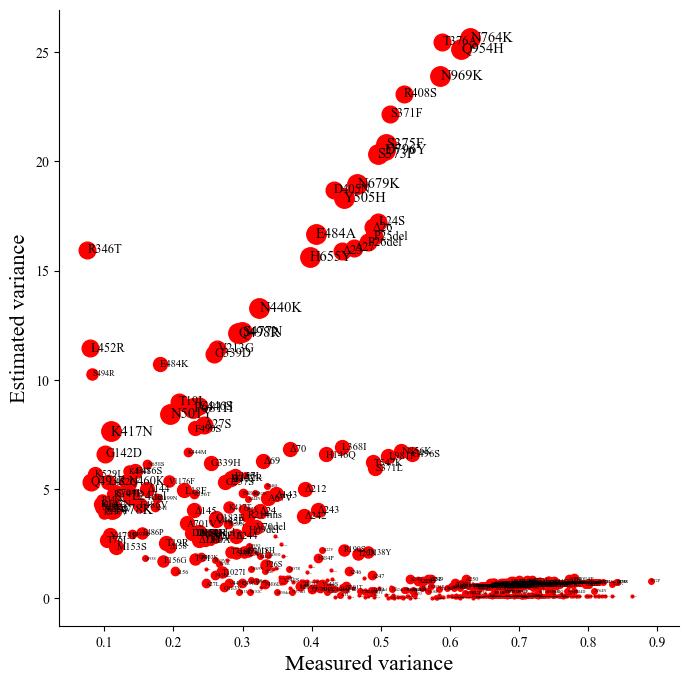

In [8]:
def get_size_from_N(x):
    if x < 10:
        return 2
    elif x < 30:
        return 4
    elif x < 100:
        return 6
    elif x < 300:
        return 8
    elif x < 1000:
        return 10
    elif x < 3000:
        return 12
    elif x < 10000:
        return 14

fig, ax = plt.subplots(figsize=(8, 8))
for _, row in var_df.iterrows():
    ax.plot(row['var(βj)'], row['s^2 est'], 'o', color='red', markersize=get_size_from_N(row['N']))
    ax.text(row['var(βj)'], row['s^2 est'], row['Mutation'], fontsize=0.75*get_size_from_N(row['N']), ha='left', va='center')
    
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('Estimated variance', fontsize=16);
ax.set_xlabel('Measured variance', fontsize=16);

fig.savefig('figs/ALTERNATE_FIGURE_3/scatter.png', dpi=300);

In [9]:
var_df.sort_values(by='var(βj)', ascending=False)

,Mutation,N,VIF,var(Xj),var(βj),s^2 est
222,I472P,27.0,30.000000,0.005144,0.891320,0.798042
165,G261F,4.0,30.000000,0.000765,0.863077,0.114989
27,A575S,27.0,30.000000,0.005144,0.842296,0.754147
457,Q474S,27.0,30.000000,0.005144,0.841980,0.753865
223,I569V,27.0,30.000000,0.005144,0.841388,0.753334
...,...,...,...,...,...,...
265,K529L,448.0,6.207225,0.078432,0.086055,5.678202
563,S494R,261.0,1.981797,0.047483,0.082022,10.262347
462,Q493R,1740.0,17.460988,0.222201,0.079937,5.312077
318,L452R,1422.0,7.210325,0.198171,0.079726,11.442484


In [10]:
pairs

,Mutation,Base Voc,s1,s2
0,G142D,Delta,45 0.562266 69 0.048169 71 -0.19...,81 0.039198 83 0.039198 93 -0.20...
1,M153S,BA.5,3608 0.347677 3623 0.339622 3629 0.14...,3636 0.132750 3637 0.241063 3639 -0.00...
2,N501Y,WuG,3571 0.429283 3576 0.348748 3585 -0.21...,3569 0.328155 3570 0.393381 3572 0.34...
3,Q493R,BA.5,3623 0.339622 3637 0.241063 3650 0.15...,3608 0.347677 3629 0.144625 3636 0.13...
4,T76I,BA.5,3608 0.347677 3623 0.339622 3629 0.14...,3636 0.132750 3637 0.241063 3639 -0.00...
5,Δ157,Delta,45 0.562266 69 0.048169 71 -0.19...,386 0.444794 477 0.097799 1542 0.26...


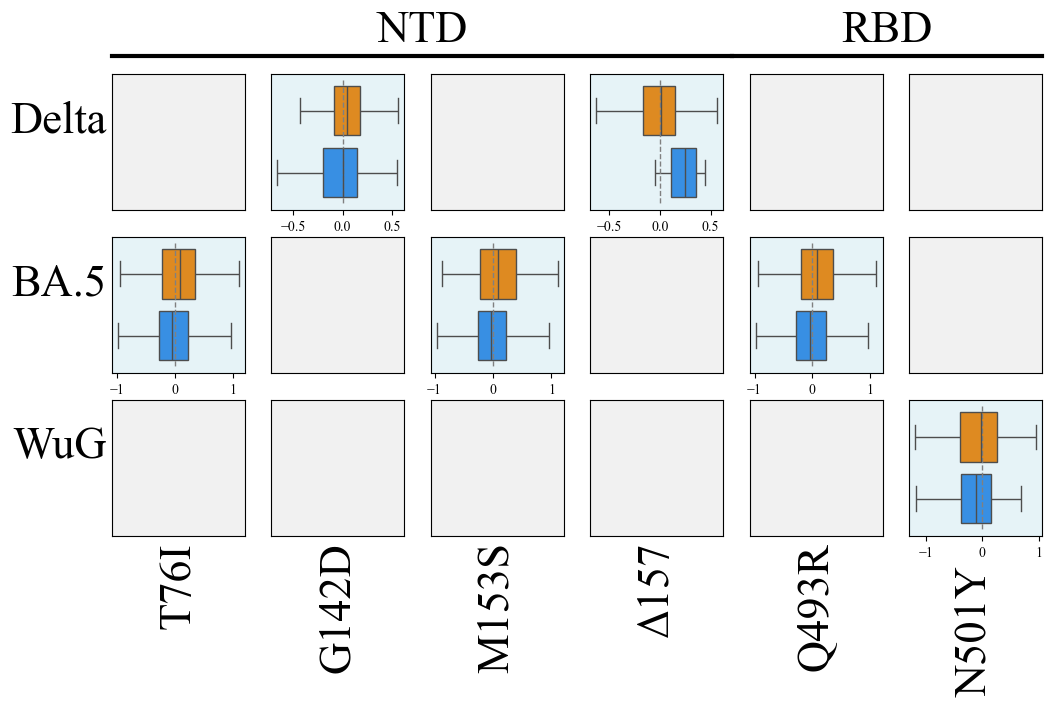

In [11]:
pairs['Position'] = pairs['Mutation'].apply(lambda x: int(''.join([_ for _ in x if _.isdigit()])))
rows = {voc:i for i, voc in enumerate(pairs['Base Voc'].unique())}
cols = {mut:i for i, mut in enumerate(pairs.sort_values(by=['Position', 'Mutation'])['Mutation'].unique())}

fontsize=32

palette = {'Present':'#fe8d01',
           'Absent':'#1c90ff'}

fig, axes = plt.subplots(len(rows), len(cols), figsize=(2*len(cols), 2*len(rows)))
for i, mut in enumerate(cols.keys()):
    for j, voc in enumerate(rows.keys()):
        ax = axes[rows[voc], cols[mut]]
        
        row = pairs.loc[(pairs['Base Voc']==voc) & (pairs['Mutation']==mut)].reset_index(drop=True)
        if len(row)!=1:
            ax.set_xticks([]);
            ax.set_yticks([]);
            xlim = [0,1]; ylim = [0,1]
            ax.fill_between(xlim, [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='lightgray', alpha=0.3)
            ax.set_xlim(xlim); ax.set_ylim(ylim);
            # ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
        else:
            row = row.loc[0]
            s1 = row['s1']
            s2 = row['s2']
            temp = pd.concat([pd.DataFrame({mut:'Present', 'Difference between predicted and observed log fold reduction':s1}),
                              pd.DataFrame({mut:'Absent',  'Difference between predicted and observed log fold reduction':s2})
                             ])

            ax = axes[rows[voc], cols[mut]]
            sns.boxplot(x='Difference between predicted and observed log fold reduction',
                        y=mut,
                        hue=mut,
                        data=temp,
                        showfliers=False,
                        palette=palette,
                        ax=ax)
            
            ax.vlines(0, -0.5, 1.5, linestyle='--', linewidth=1, color='gray');
            ax.set_xlabel('');
            ax.set_ylabel('');
            ax.set_yticks([]);
            xlim = ax.get_xlim(); ylim = ax.get_ylim();
            ax.fill_between(xlim, [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='lightblue', alpha=0.3)
            ax.set_xlim(xlim); ax.set_ylim(ylim);
            
            
        if i==0:
            ax.set_ylabel(voc, rotation=0, fontsize=fontsize, ha='right')
        if j==len(rows)-1:
            ax.set_xlabel(mut, rotation=90, fontsize=fontsize)
            
# Get the first and last axes to determine grid boundaries
ax_left = axes[0, 0].get_position().x0
ax_right = axes[0, -1].get_position().x1
ax_bottom = axes[-1, 0].get_position().y0
ax_top = axes[0, 0].get_position().y1
# Compute exact column width based on subplot positions
column_width = (ax_right - ax_left) / len(cols)

regions = {'NTD':[13,304],
           'RBD':[417,505],
           # '':[438, 508], # RBM
           'FCS':[672,709],
           'FP':[788, 806],
           'IFP':[816, 833],
           'HR1':[918,983],
           'HR2':[1162,1203]}
region_patches = {}
# Add shading behind the relevant columns
vert_pad = 0.15
for r in regions:
    start = np.inf
    end = -1
    for i, mut in enumerate(cols.keys()):
        pos = int(''.join([_ for _ in mut if _.isdigit()]))
        if pos >= regions[r][0] and pos <= regions[r][1]:
            if i <= start:
                start = i
                end = i+1
            if i >= end:
                end = i+1
    if start != np.inf and end != -1:
        region_patches[r] = [start, end]

for r in region_patches:
    x_start = ax_left + region_patches[r][0] * column_width  # Compute exact position
    rect_range = region_patches[r][1] - region_patches[r][0]
    x_end = x_start + rect_range * column_width
    # fig.patches.append(Rectangle(
    #     (x_start, ax_bottom-vert_pad), rect_range * column_width, ax_top - ax_bottom + 1.2*vert_pad,  # (x, y), width, height
    #     transform=fig.transFigure, color='lightblue', alpha=0.3,
    #     zorder=-1  # Send it to the background
    # ))
    line = Line2D([x_start, x_end], [ax_top + 0.2*vert_pad, ax_top + 0.2*vert_pad], 
                     transform=fig.transFigure, color='black', linewidth=3)
    fig.add_artist(line)
    fig.text(x_start + rect_range * column_width / 2, ax_top + 0.25*vert_pad, r, 
                 ha='center', va='bottom', fontsize=fontsize)


In [12]:
var_df[var_df['s^2 est']>0.0085].sort_values(by='s^2 est', ascending=False)

,Mutation,N,VIF,var(Xj),var(βj),s^2 est
397,N764K,3264.0,30.0,0.234438,0.629014,25.668665
615,T376A,2823.0,30.0,0.248408,0.588976,25.467023
480,Q954H,3264.0,30.0,0.234438,0.616404,25.154091
402,N969K,3264.0,30.0,0.234438,0.586353,23.927793
509,R408S,2823.0,30.0,0.248408,0.534064,23.092672
...,...,...,...,...,...,...
731,Y489H,1.0,30.0,0.000191,0.573575,0.019116
84,E1072K,1.0,30.0,0.000191,0.542250,0.018072
190,H146N,1.0,30.0,0.000191,0.531716,0.017720
67,D405K,1.0,30.0,0.000191,0.518532,0.017281


In [13]:
# Manhattan plot
def setup(ax, ylim, options=dict()):
    options['xlim'] = [0, 1273]
    options['ylim'] = ylim #[-1, 1]
    
    ax.set_xlim(options['xlim'])
    ax.set_ylim(options['ylim'])
    
    ax.set_ylabel('Mutation effect', fontsize=options.get('fontsize', 8)*2)
    ax.set_xlabel('Spike AA Position', fontsize=options.get('fontsize', 8)*2)

    return options

def get_positions(mutations):
    coefficients = mutations.copy()
    
    positions = [int(''.join(filter(str.isdigit, c))) for c in coefficients] #[int(c[1:-1]) for c in coefficients]
    return positions, coefficients

def plot_coef(ax, effects, positions, mutations, options):
    ax.plot(positions, effects, 'ro', markersize=options.get('markersize', 10))
    
    texts = []
    for i, (pos, fea) in enumerate(zip(positions, mutations)):
        x = pos
        y = effects[i]
        text = fea #+ '\n' + '{:1.2f}'.format(y)
        texts.append(ax.annotate(text, xy=(x, y), xytext=(x, y), fontsize=options.get('fontsize', 8)))

    # adjust_text(texts);
    
    ax.set_xlim(options['xlim'])
    
def plot_regions(ax, options):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    
    for r in regions:
        ax.vlines(regions[r], options['ylim'][0], options['ylim'][1], linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.fill_between(regions[r], options['ylim'][0], options['ylim'][1], color='tab:blue', alpha=0.1)
        ax.text(np.mean(regions[r]), options['ylim'][1]*0.95, r, ha='center', va='top', fontsize=options.get('fontsize', 8)*0.75)

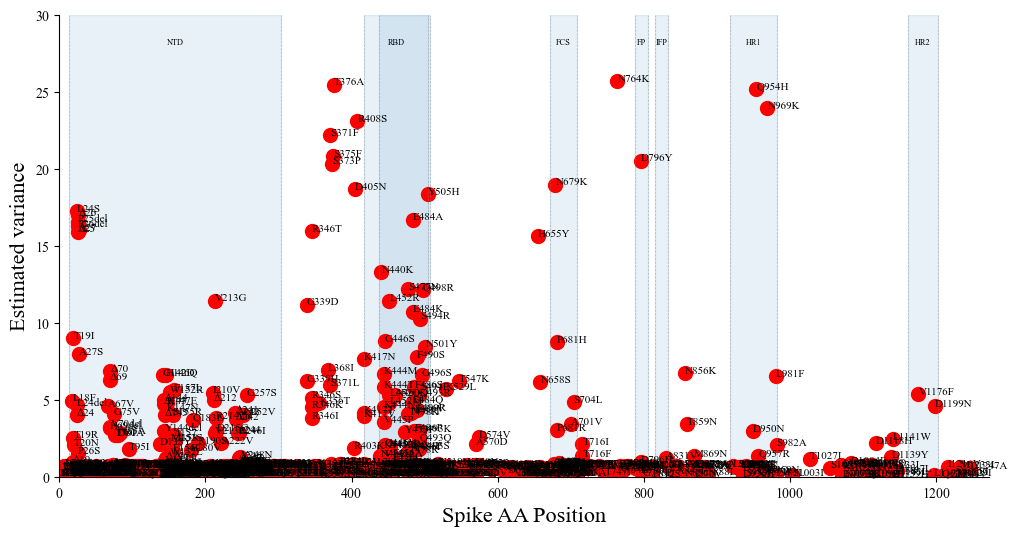

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
options = setup(ax, [0, 30])
positions, mutations = get_positions(var_df['Mutation'])
plot_coef(ax, var_df['s^2 est'], positions, mutations, options)
plot_regions(ax, options)
# ax.set_title('Estimated True Variance', fontsize=18);
ax.spines[['top', 'right']].set_visible(False);

ax.set_ylabel('Estimated variance', fontsize=16);

fig.savefig('figs/ALTERNATE_FIGURE_3/manhattan.png', dpi=300);

In [15]:
def format_ax(ax, bg_color):
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_yticks([]);
    xlim = ax.get_xlim(); ylim = ax.get_ylim();
    ax.fill_between(xlim, [ylim[0], ylim[0]], [ylim[1], ylim[1]], color=bg_color, alpha=0.3)
    ax.set_xlim(xlim); ax.set_ylim(ylim);
    
def annotate_regions(fig, axes, cols, regions):
    # Get the first and last axes to determine grid boundaries
    ax_left = min(ax.get_position().x0 for row in axes for ax in row)
    ax_right = max(ax.get_position().x1 for row in axes for ax in row)
    ax_top = max(ax.get_position().y1 for row in axes for ax in row)
    # Compute exact column width based on subplot positions
    column_width = (ax_right - ax_left) / len(cols)

    region_patches = {}
    # Add line over the relevant columns
    vert_pad = 0.15
    for r in regions:
        start = np.inf
        end = -1
        for i, mut in enumerate(cols.keys()):
            pos = int(''.join([_ for _ in mut if _.isdigit()]))
            if pos >= regions[r][0] and pos <= regions[r][1]:
                if i <= start:
                    start = i
                    end = i+1
                if i >= end:
                    end = i+1
        if start != np.inf and end != -1:
            region_patches[r] = [start, end]

    for r in region_patches:
        x_start = ax_left + region_patches[r][0] * column_width  # Compute exact position
        rect_range = region_patches[r][1] - region_patches[r][0]
        x_end = x_start + rect_range * column_width

        line = Line2D([x_start, x_end], [ax_top + 0.2*vert_pad, ax_top + 0.2*vert_pad], 
                         transform=fig.transFigure, color='black', linewidth=3)
        fig.add_artist(line)
        fig.text(x_start + rect_range * column_width / 2, ax_top + 0.25*vert_pad, r, 
                     ha='center', va='bottom', fontsize=fontsize)
        
def get_size_from_N(x):
    if x < 10:
        return 4*3
    elif x < 30:
        return 8*3
    elif x < 100:
        return 12*3
    elif x < 300:
        return 16*3
    elif x < 1000:
        return 20*3
    elif x < 3000:
        return 24*3
    elif x < 10000:
        return 28*3

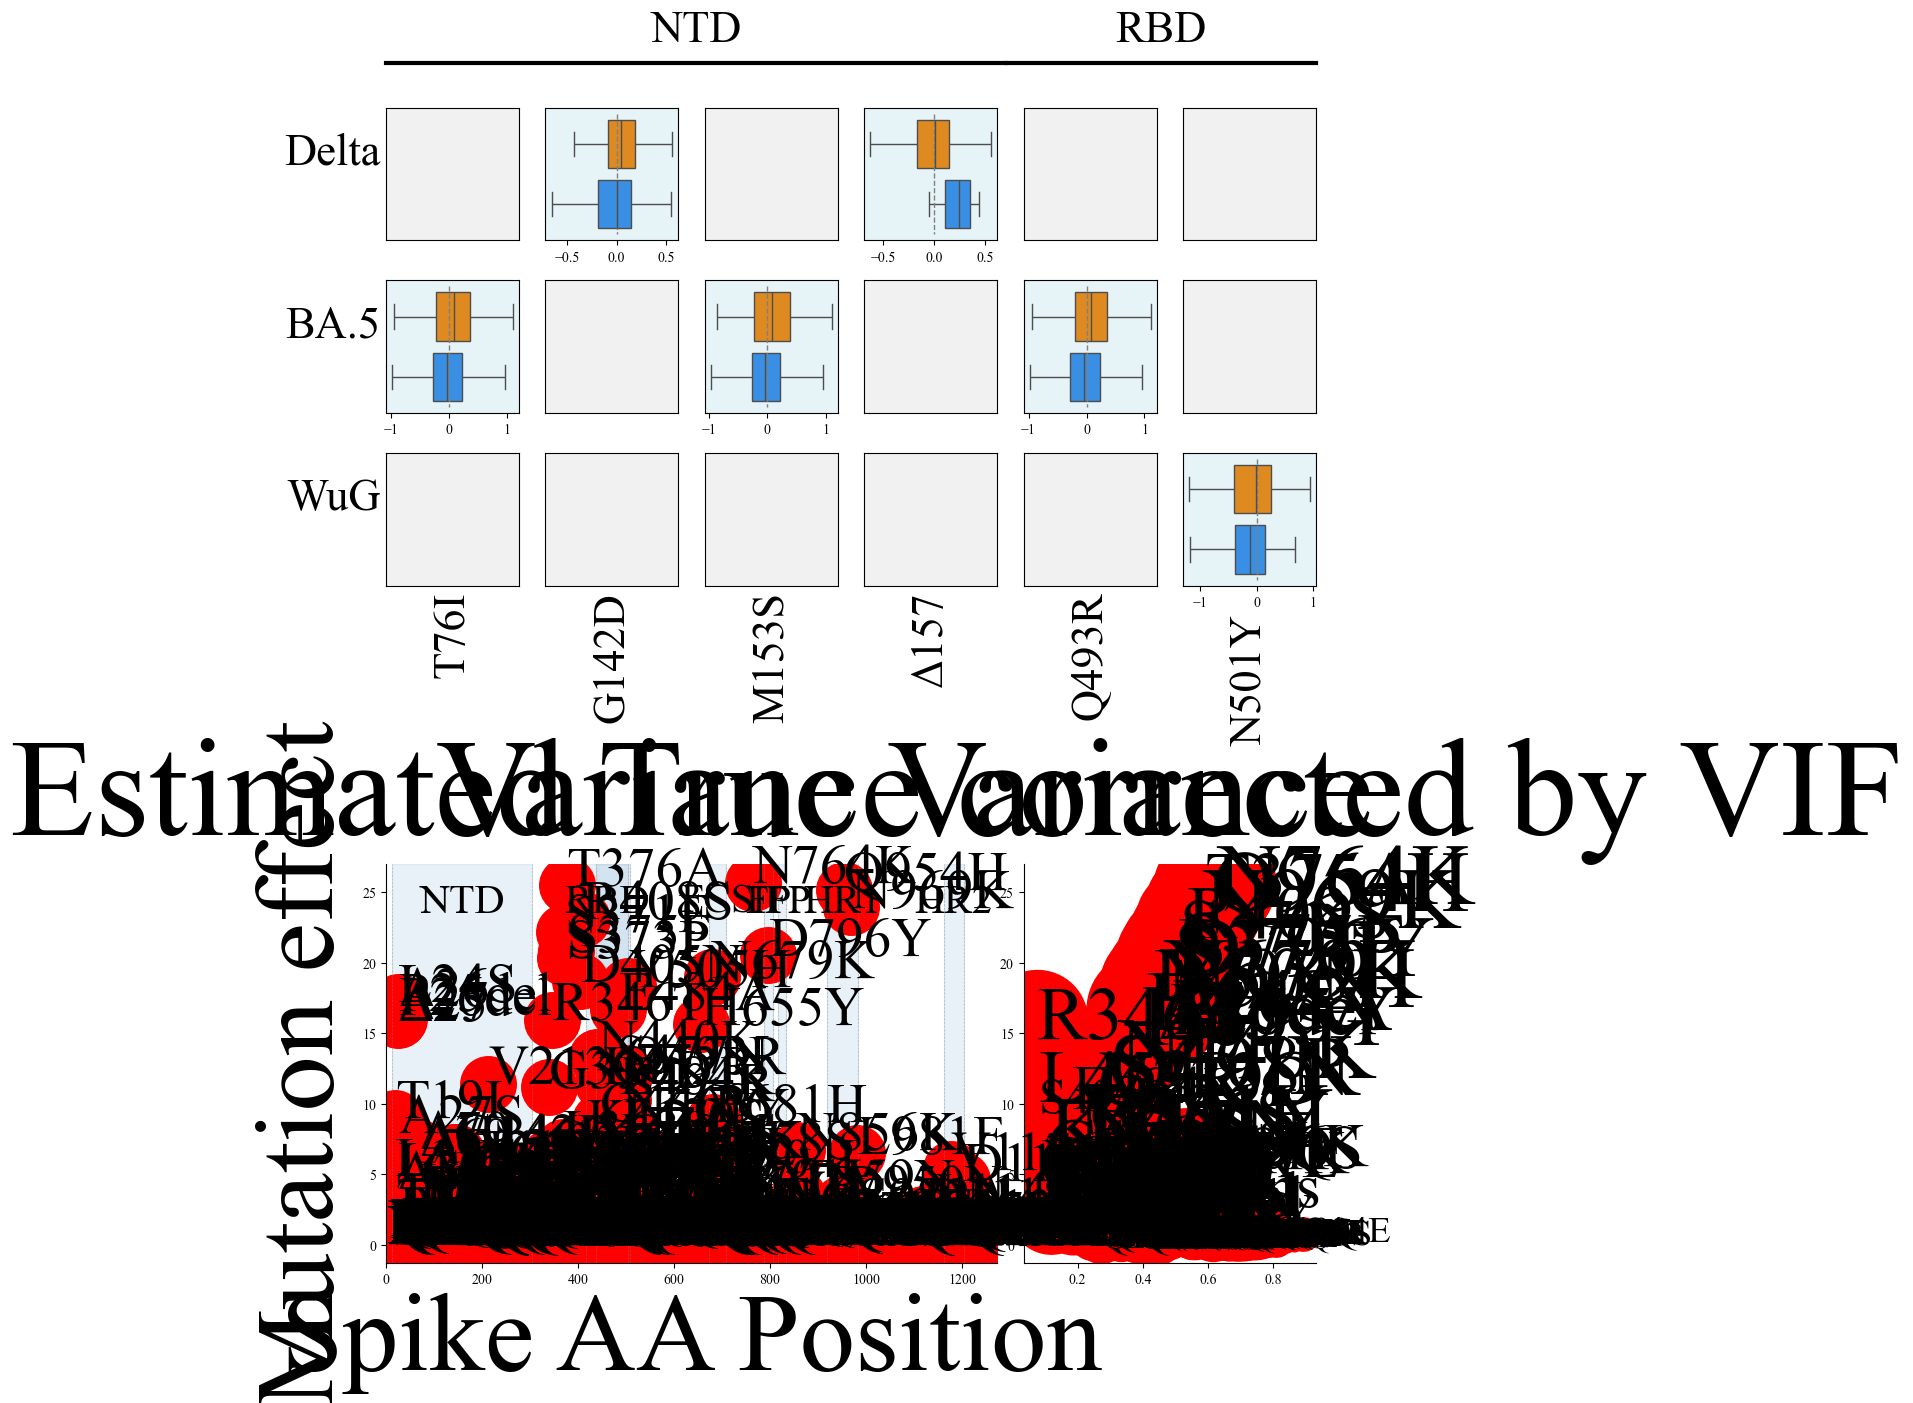

In [16]:
# Plot facetplot as a top banner, plot bubble plot in bottom right, plot structures at bottom middle and bottom left

# For top plot, how many rows and columns should the facetplot have?
rows = {voc:i for i, voc in enumerate(pairs['Base Voc'].unique())}
cols = {mut:i for i, mut in enumerate(pairs.sort_values(by=['Position', 'Mutation'])['Mutation'].unique())}

# Set up fig
fig = plt.figure(figsize=(2*len(cols), 2*len(rows)+3+len(cols)))
gs = gridspec.GridSpec(len(rows)+1+1, len(cols), figure=fig, width_ratios=[2]*len(cols), height_ratios=[2]*len(rows) + [3] + [len(cols)])

##############################################################################################################################################################
# Top Plot
##############################################################################################################################################################
# Set some params
fontsize=32
palette = {'Present':'#fe8d01',
           'Absent':'#1c90ff'}

axes_list = [] 
for i, mut in enumerate(cols.keys()):
    row_axes = []
    for j, voc in enumerate(rows.keys()):
        ax = fig.add_subplot(gs[rows[voc], cols[mut]])
        
        # Is this mut flagged for potential epistasis in this base voc?
        row = pairs.loc[(pairs['Base Voc']==voc) & (pairs['Mutation']==mut)].reset_index(drop=True)
        if len(row)!=1:  # Not flagged
            ax.set_xticks([]);
            format_ax(ax, 'lightgray')

        else: # flagged
            row = row.loc[0]
            s1 = row['s1']; s2 = row['s2']
            temp = pd.concat([pd.DataFrame({mut:'Present', 'Difference between predicted and observed log fold reduction':s1}),
                              pd.DataFrame({mut:'Absent',  'Difference between predicted and observed log fold reduction':s2})
                             ])
            sns.boxplot(x='Difference between predicted and observed log fold reduction',
                        y=mut,
                        hue=mut,
                        data=temp,
                        showfliers=False,
                        palette=palette,
                        ax=ax)
            ax.vlines(0, -0.5, 1.5, linestyle='--', linewidth=1, color='gray');
            
            format_ax(ax, 'lightblue')


        if i==0:
            ax.set_ylabel(voc, rotation=0, fontsize=fontsize, ha='right')
        if j==len(rows)-1:
            ax.set_xlabel(mut, rotation=90, fontsize=fontsize)
            
        row_axes.append(ax)
    axes_list.append(row_axes)
annotate_regions(fig, axes_list, cols, regions)

##############################################################################################################################################################
# Bottom Plots
##############################################################################################################################################################
ax = fig.add_subplot(gs[-1, 2*len(cols)//3:])
ax.set_title('Variance corrected by VIF', fontsize=100);
for _, row in var_df.iterrows():
    ax.plot(row['var(βj)'], row['s^2 est'], 'o', color='red', markersize=get_size_from_N(row['N']))
    ax.text(row['var(βj)'], row['s^2 est'], row['Mutation'], fontsize=0.75*get_size_from_N(row['N']), ha='left', va='center') 
ax.spines[['top', 'right']].set_visible(False);
ylim = ax.get_ylim()

ax = fig.add_subplot(gs[-1:, :2*len(cols)//3])
options = dict(); options['fontsize']=40; options['markersize']=40; 
options = setup(ax, ylim, options); 
positions, mutations = get_positions(var_df['Mutation'])
plot_coef(ax, var_df['s^2 est'], positions, mutations, options)
plot_regions(ax, options)
ax.set_title('Estimated True Variance', fontsize=100);
ax.spines[['top', 'right']].set_visible(False);